# WMIR practice lesson

### Objective
Train an SVM model on the QuestionClassification dataset using different representations.  
Compare then different non linear definitions of the model (`polynomial` vs `rbf`).  
Some exercises are given with an incresing difficulty.

#### Author
Claudiu Daniel Hromei, April 2023.

# Required Libraries

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [2]:
# option to print all the value of cells in DataFrames
pd.set_option("max_colwidth", None)

# Question Classification dataset
We will use a different dataset, whose objective is to classify the given Questions into respective categories based on what type of answer it expects such as a numerical answer or a text description or a place or human name etc.
Load the dataset and print the classes

In [3]:
training_data = pd.read_csv("./data/train.csv")
testing_data = pd.read_csv("./data/test.csv")

classes = list(np.unique(testing_data['classes']))
print(classes)

['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']


Let's see some examples.

In [4]:
training_data.head(10)

,questions,classes
0,How did serfdom develop in and then leave Russia ?,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real names ?,DESC
3,What fowl grabs the spotlight after the Chinese Year of the Monkey ?,ENTY
4,What is the full form of .com ?,ABBR
5,What contemptible scoundrel stole the cork from my lunch ?,HUM
6,What team did baseball 's St. Louis Browns become ?,HUM
7,What is the oldest profession ?,HUM
8,What are liver enzymes ?,DESC
9,Name the scar-faced bounty hunter of The Old West .,HUM


We can plot the number of examples for each class.

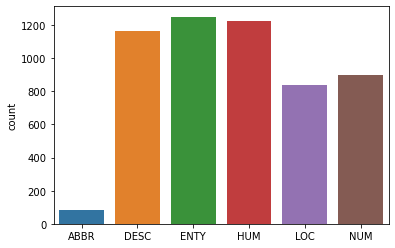

In [5]:
training_plot = sns.countplot(x=sorted(training_data['classes']))

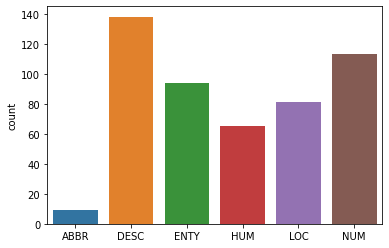

In [6]:
testing_plot = sns.countplot(x=sorted(testing_data['classes']))

# Support Vector Machines

Definition of the model using the Bag-of-Words (tf-idf) formulation from previous exercises in order to compute some hyperplanes for the classification.  

An overview of the main parameters:

- **C**: `float`, default=`1.0`  
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- **kernel**: `{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}` or callable, default=`'rbf'`  
Specifies the kernel type to be used in the algorithm. If none is given, `‘rbf’` will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape `(n_samples, n_samples)`.

- **degree**: `int`, default=`3`  
Degree of the polynomial kernel function (`‘poly’`). Must be non-negative. Ignored by all other kernels.

- **gamma**: `{‘scale’, ‘auto’}` or `float`, default=`’scale’`  
Kernel coefficient for `‘rbf’`, `‘poly’` and `‘sigmoid’`.

  - if gamma = `'scale'` (default) is passed then it uses `1 / (n_features * X.var())` as value of gamma,
  - if `‘auto’`, uses `1 / n_features`
  - if `float`, must be non-negative.

- **verbose**: `bool`, default=`False`  
Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.

- **max_iter**: `int`, default=`-1`  
Hard limit on iterations within solver, or `-1` for no limit.

- **decision_function_shape**: `{‘ovo’, ‘ovr’}`, default=`’ovr’`  
Whether to return a one-vs-rest (`‘ovr’`) decision function of shape `(n_samples, n_classes)` as all other classifiers, or the original one-vs-one (`‘ovo’`) decision function of libsvm which has shape `(n_samples, n_classes * (n_classes - 1) / 2)`. However, note that internally, one-vs-one (`‘ovo’`) is always used as a multi-class strategy to train models; an ovr matrix is only constructed from the ovo matrix. The parameter is ignored for binary classification.

Notice that we are using the `polynomial` version of the SVM model, so the `degree` **must** be defined.

## SVM - BoW

Let's apply again the Bag-of-Word (tf-idf) policy to encode these sentences and evaluate an SVM model.

In [7]:
# Extract features from the dataset
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(training_data['questions'].tolist())
X_test = vectorizer.transform(testing_data['questions'].tolist())
y_train = training_data['classes'].tolist()
y_test = testing_data['classes'].tolist()

In [8]:
C = 1
decision_function_shape = 'ovr' 
max_iter = -1
kernel = "poly"
degree = 5
gamma = 4

In [9]:
svm = SVC(C=C, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)

svm.fit(X_train, y_train)

SVC(C=1, degree=5, gamma=4, kernel='poly')

In [10]:
y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        ABBR       0.67      0.44      0.53         9
        DESC       0.84      0.76      0.80       138
        ENTY       0.35      0.86      0.50        94
         HUM       0.58      0.82      0.68        65
         LOC       0.87      0.25      0.38        81
         NUM       0.95      0.19      0.31       113

    accuracy                           0.57       500
   macro avg       0.71      0.55      0.53       500
weighted avg       0.74      0.57      0.54       500



In [11]:
from sklearn.model_selection import cross_val_score

scores = []
degrees_list = [3,4]
for d in degrees_list:
    print(d)
    svm = SVC(C=C, max_iter=max_iter, degree=d, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
    mean_score = cross_val_score(svm, X_train, y_train, cv=5, scoring="f1_macro").mean()
    print(mean_score)
    scores.append((d, mean_score))
    print(20*"*")

print(scores)

3
0.6510732388958493
********************
4
0.47072928788254476
********************
[(3, 0.6510732388958493), (4, 0.47072928788254476)]


---

Let's try using a more advanced kernel: the Radial Basis Function (`rbf`). It is defined as the exponential of the Squared Euclidean Distance between two feature vectors in a space, multiplied by a parameter `gamma`. The output ranges between 0 and 1 (when `x=x'`) and it has a ready interpretation as a *similarity measure*.

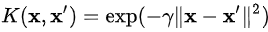

In [12]:
svm = SVC(C=C, max_iter=max_iter, degree=0, kernel='rbf', gamma=gamma, decision_function_shape=decision_function_shape)

svm.fit(X_train, y_train)

SVC(C=1, degree=0, gamma=4)

In [13]:
y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        ABBR       0.67      0.44      0.53         9
        DESC       0.81      0.78      0.79       138
        ENTY       0.34      0.93      0.50        94
         HUM       0.71      0.85      0.77        65
         LOC       1.00      0.20      0.33        81
         NUM       1.00      0.09      0.16       113

    accuracy                           0.56       500
   macro avg       0.75      0.55      0.51       500
weighted avg       0.78      0.56      0.51       500



## Neural Encodings

Definition of the model using a different policy to compute the representation of the test. Recently, advanced models were introduced,  called [Transformers](https://jalammar.github.io/illustrated-transformer/) able to represent words in context (in the sentence): e.g. the word *bank* has at least two differnt meanings, depending on the sentence in which is found  
- "*The **bank** of the river.*"  
- "*I asked the **bank** for a loan*".  

These Transformers will produce different representations based on the context. On the other hand, the classic Bag-of-Words approach will produce the same representation either for the side of the river and the financial institution.

We can leverage the ability of the Transformers in order to produce the numerical representation of the sentences from our dataset and then use the SVM model for classification. The `get_embeddings` method here calls the Transformer named `'msmarco-distilbert-base-v2'` to get the numerical representation in a similar manner as we called the Vectorizer to produce the `tf-idf` vectors previously.  

More about the Transformers topic in the next lessons!

Take away: *we are injecting contextual knowledge into the SVM model*!

---

**WARNING**: you need to activate the GPU setting for this notebook. If you're using the Jupyter Notebook Environment pass over this, if you're using the Google Colab environment you need to:  
- click on "*Runtime*"
- click on "*Change Runtime type*"
- on "*Hardware accelerator*" choose "*GPU*" from the dropdown list
- click on *Save* and run this Notebook again

I already computed this embeddings and we will load them from file. If you want to use this model and compute them for yourself, execute this in a code cell:

```
# install the library
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
import torch

def get_embeddings(sentences: List[str]) -> List[float]:
    model = SentenceTransformer('msmarco-distilbert-base-v2')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model.encode(sentences, batch_size=640, device="cuda:0", show_progress_bar=True).tolist()

X_train_sbert = get_embeddings(newsgroups_train.data)
X_test_sbert = get_embeddings(newsgroups_test.data)
```

Load the embeddings from file here and print the first question and its embedding.

In [14]:
X_train_sbert = []
with open("./data/train_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_train_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])
    
X_test_sbert = []
with open("./data/test_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_test_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])

In [15]:
print(training_data['questions'].tolist()[20], "\n", X_train_sbert[20])

What is the date of Boxing Day ? 
 [-0.30974090099334717, 0.50898277759552, 0.08072645962238312, -0.9401206970214844, -0.8128250241279602, -0.6734052896499634, -0.01927994191646576, 0.9211580157279968, 1.4949185848236084, 0.20072388648986816, -0.20275887846946716, 0.16153311729431152, -0.2628682851791382, -0.17560765147209167, -0.21005120873451233, 0.8293363451957703, -0.08906467258930206, -0.1669425219297409, 0.218394473195076, 0.07574951648712158, -0.4972553849220276, 0.40407174825668335, 0.06028851866722107, 0.7163890600204468, 0.3213236629962921, 0.9732807278633118, 0.07892663776874542, 0.43038350343704224, 0.286204993724823, 0.04079986363649368, 0.6179925203323364, -0.15243706107139587, -0.37264516949653625, 0.6823400259017944, -0.19847342371940613, 0.30428916215896606, 0.9350379705429077, 0.8051928281784058, -0.5906075239181519, 0.5509642362594604, -0.5492445826530457, -0.07955031096935272, 0.8939704895019531, 0.1667163372039795, -1.0867096185684204, 0.4705183506011963, 0.5635088

Let's take 2 similar questions and a very different one. We take their texts, their indexes, we can apply the *PCA* to compute the first 3 eigen-vectors and plot them as the previous lessons to visualize the representations in the vectorial space.

In [16]:
q1 = "What is the date of Boxing Day ?"
q1_index = training_data.index[training_data['questions'] == q1].tolist()[0]

q2 = "What is the date of Bastille Day ?"
q2_index = training_data.index[training_data['questions'] == q2].tolist()[0]

q3 = "Where can I find a case on Individuals with Disabilities Education Act of 1991 ?"
q3_index = training_data.index[training_data['questions'] == q3].tolist()[0]

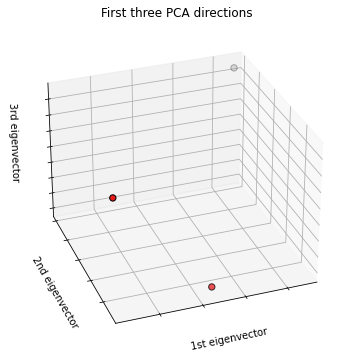

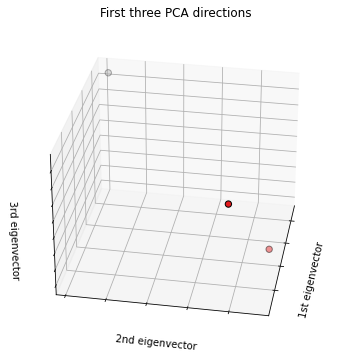

In [17]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X_train_sbert)
X_reduced_selected = [X_reduced[q1_index].tolist(), X_reduced[q2_index].tolist(), X_reduced[q3_index].tolist()]

ax.scatter(
    [x[0] for x in X_reduced_selected], # asse x
    [x[1] for x in X_reduced_selected], # asse y
    #[0, 0, 0], # asse z
    [x[2] for x in X_reduced_selected],
    c=[y_train.index(y_train[q1_index]), y_train.index(y_train[q2_index]), y_train.index(y_train[q3_index])],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

### second plot ###
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=170)

ax.scatter(
    [x[0] for x in X_reduced_selected], # asse x
    [x[1] for x in X_reduced_selected], # asse y
    #[0, 0, 0], # asse z
    [x[2] for x in X_reduced_selected],
    c=[y_train.index(y_train[q1_index]), y_train.index(y_train[q2_index]), y_train.index(y_train[q3_index])],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

The two red dots are `q1` and `q2`, very similar questions, both concerning the dates of two events. Notice how close they are in this 3D space.  
The gray one is `q3`, concerning some Educational Act, that is in the very far corner of the space with respect to the other two.

#### The SVM model
Now we train an SVM model

In [18]:
svm_with_sbert = SVC(C=C, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)

svm_with_sbert.fit(X_train_sbert, y_train)

SVC(C=1, degree=5, gamma=4, kernel='poly')

In [19]:
y_pred_sbert = svm_with_sbert.predict(X_test_sbert)

print(classification_report(y_test, y_pred_sbert, target_names=classes))

              precision    recall  f1-score   support

        ABBR       1.00      0.33      0.50         9
        DESC       0.85      0.24      0.37       138
        ENTY       0.30      0.93      0.46        94
         HUM       0.64      0.95      0.77        65
         LOC       0.93      0.51      0.66        81
         NUM       0.97      0.26      0.41       113

    accuracy                           0.51       500
   macro avg       0.78      0.54      0.53       500
weighted avg       0.76      0.51      0.50       500



--- 

Let's try the rbf kernel on the neural encodings as well

In [20]:
svm = SVC(C=C, max_iter=max_iter, degree=0, kernel='rbf', gamma=gamma, decision_function_shape=decision_function_shape)

svm.fit(X_train, y_train)

SVC(C=1, degree=0, gamma=4)

In [21]:
y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

        ABBR       0.67      0.44      0.53         9
        DESC       0.81      0.78      0.79       138
        ENTY       0.34      0.93      0.50        94
         HUM       0.71      0.85      0.77        65
         LOC       1.00      0.20      0.33        81
         NUM       1.00      0.09      0.16       113

    accuracy                           0.56       500
   macro avg       0.75      0.55      0.51       500
weighted avg       0.78      0.56      0.51       500



### Exercise 1: Create a mini test set

Create some questions (20, 30, ... 100) and assign them a label accordingly to this dataset (e.g. `DESC` or `LOC`). Then take the best model you trained until now, make the predictions on this invented questions and evaluate it. Provide the `classification_report` output as shown before.

```
new_questions = [
    "Where was Napoleon born?",
    ...
]

new_labels = [
    "LOC",
    ...
]
```

---
**WARNING**: You need to use the BoW representations OR invoke the Transformer model on Colab to get the neural encodings.

### Exercise 2: The best model

Optimize **all** the parameters of the SVM in order to get the best possible model using the BoW representation. Define `k` for nested loops, one for each parameter and use the `cross_val_score` method on the training set to get a score. Take the best configuration of parameters, train the SVM model on the training set and test it on the testing set.

```
for c in C_list:
    for kernel in kernels_list:
        for ...
            for ...
                    ...
                        svm = SVC(<params here>)
                        mean_score = cross_val_score(<params here>)
```